In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
from scipy import sparse

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import joblib
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

In [2]:
X = sparse.load_npz("../data/processed/vectorized.npz")
df_labels = pd.read_csv("../data/processed/cleaned.csv")
y = df_labels["label"].values

In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [4]:
logreg = LogisticRegression(max_iter=300, solver='liblinear', random_state=42)
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_test)

In [5]:
nb = MultinomialNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)

In [6]:
print("🔍 Logistic Regression Report:\n")
print(classification_report(y_test, y_pred_logreg, target_names=["Fake", "Real"]))

print("\n🔍 Naive Bayes Report:\n")
print(classification_report(y_test, y_pred_nb, target_names=["Fake", "Real"]))

🔍 Logistic Regression Report:

              precision    recall  f1-score   support

        Fake       0.99      0.99      0.99      4696
        Real       0.98      0.99      0.99      4284

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980


🔍 Naive Bayes Report:

              precision    recall  f1-score   support

        Fake       0.93      0.94      0.94      4696
        Real       0.93      0.93      0.93      4284

    accuracy                           0.93      8980
   macro avg       0.93      0.93      0.93      8980
weighted avg       0.93      0.93      0.93      8980



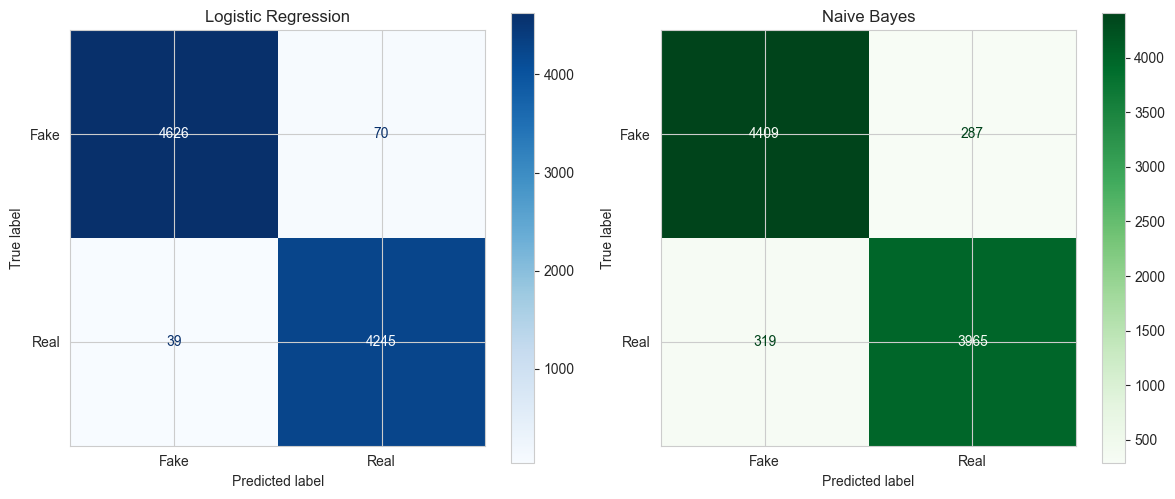

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_logreg, ax=axs[0], display_labels=["Fake", "Real"], cmap="Blues")
axs[0].set_title("Logistic Regression")

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_nb, ax=axs[1], display_labels=["Fake", "Real"], cmap="Greens")
axs[1].set_title("Naive Bayes")

plt.tight_layout()
plt.show()

In [8]:
models_dir = Path("../models")
models_dir.mkdir(parents=True, exist_ok=True)

joblib.dump(logreg, models_dir / "logreg_model.pkl")
joblib.dump(nb, models_dir / "naive_bayes_model.pkl")

['..\\models\\naive_bayes_model.pkl']

In [9]:
from sklearn.model_selection import cross_val_score

logreg_scores = cross_val_score(logreg, X, y, cv=5, scoring='accuracy')
nb_scores = cross_val_score(nb, X, y, cv=5, scoring='accuracy')

print(f"Logistic Regression CV Accuracy: {logreg_scores.mean():.4f} ± {logreg_scores.std():.4f}")
print(f"Naive Bayes CV Accuracy:        {nb_scores.mean():.4f} ± {nb_scores.std():.4f}")


Logistic Regression CV Accuracy: 0.9875 ± 0.0016
Naive Bayes CV Accuracy:        0.9293 ± 0.0020


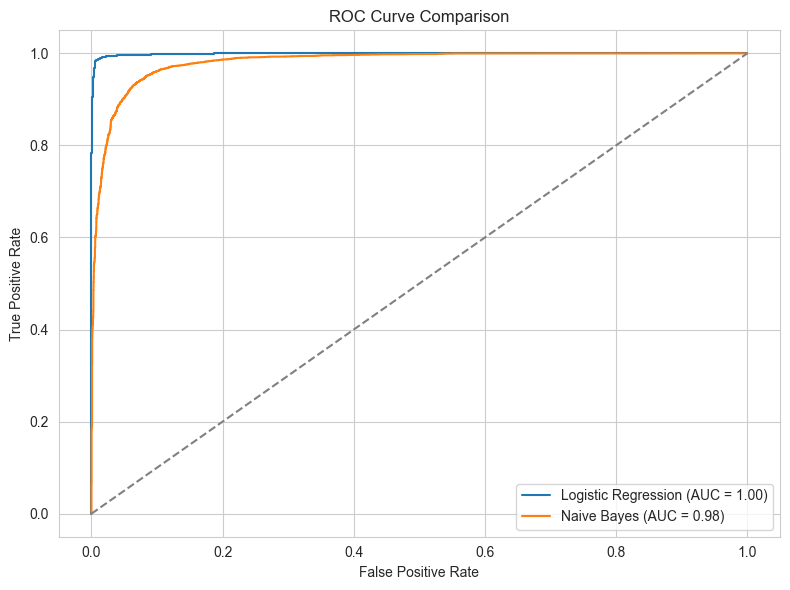

In [10]:
from sklearn.metrics import roc_curve, auc

logreg_probs = logreg.predict_proba(X_test)[:, 1]
nb_probs = nb.predict_proba(X_test)[:, 1]

fpr_logreg, tpr_logreg, _ = roc_curve(y_test, logreg_probs)
fpr_nb, tpr_nb, _ = roc_curve(y_test, nb_probs)

roc_auc_logreg = auc(fpr_logreg, tpr_logreg)
roc_auc_nb = auc(fpr_nb, tpr_nb)

plt.figure(figsize=(8, 6))
plt.plot(fpr_logreg, tpr_logreg, label=f"Logistic Regression (AUC = {roc_auc_logreg:.2f})")
plt.plot(fpr_nb, tpr_nb, label=f"Naive Bayes (AUC = {roc_auc_nb:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [11]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'solver': ['liblinear', 'lbfgs'],
    'max_iter': [100, 300]
}

grid_logreg = GridSearchCV(LogisticRegression(random_state=42), param_grid, cv=5, scoring='accuracy')
grid_logreg.fit(X_train, y_train)

print("Best Params:", grid_logreg.best_params_)
print("Best Score:", grid_logreg.best_score_)


Best Params: {'C': 10, 'max_iter': 100, 'solver': 'liblinear'}
Best Score: 0.9917589887593419


In [12]:
import yaml

with open("../configs/logreg_config.yaml") as file:
    config = yaml.safe_load(file)

logreg_config = LogisticRegression(
    C=config["model"]["params"]["C"],
    solver=config["model"]["params"]["solver"],
    max_iter=config["model"]["params"]["max_iter"],
    random_state=42
)

logreg_config.fit(X_train, y_train)
y_pred_config = logreg_config.predict(X_test)

print(classification_report(y_test, y_pred_config, target_names=["Fake", "Real"]))


              precision    recall  f1-score   support

        Fake       0.99      0.99      0.99      4696
        Real       0.98      0.99      0.99      4284

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



In [13]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB

nb_params = {'alpha': [0.01, 0.1, 0.5, 1.0, 2.0, 5.0]}

grid_nb = GridSearchCV(MultinomialNB(), nb_params, cv=5, scoring='accuracy')
grid_nb.fit(X_train, y_train)

print("Best Naive Bayes Params:", grid_nb.best_params_)
print("Best Naive Bayes Score:", grid_nb.best_score_)

Best Naive Bayes Params: {'alpha': 0.01}
Best Naive Bayes Score: 0.9313994670663567


In [15]:
from pathlib import Path
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score

report_data = {
    "Model": ["Logistic Regression", "Naive Bayes"],
    "Accuracy": [accuracy_score(y_test, y_pred_logreg), accuracy_score(y_test, y_pred_nb)],
    "F1 Score": [f1_score(y_test, y_pred_logreg), f1_score(y_test, y_pred_nb)]
}

df_report = pd.DataFrame(report_data)

reports_dir = Path("../reports")
reports_dir.mkdir(exist_ok=True)
report_path = reports_dir / "model_comparison.csv"
df_report.to_csv(report_path, index=False)

print(f"✅ Report saved to: {report_path.resolve()}")

✅ Report saved to: D:\Machine Learning Project\fake-news-detection\reports\model_comparison.csv


In [ ]:
import mlflow
import mlflow.sklearn
from mlflow.models.signature import infer_signature

mlflow.set_tracking_uri("file:../mlruns")
mlflow.set_experiment("FakeNewsDetection")

input_example = X_test[:1].toarray()
signature = infer_signature(X_test, y_pred_logreg)

with mlflow.start_run(run_name="LogReg_Baseline"):
    mlflow.log_param("C", 1.0)
    mlflow.log_param("solver", "liblinear")
    mlflow.log_metric("accuracy", accuracy_score(y_test, y_pred_logreg))
    mlflow.log_metric("f1_score", f1_score(y_test, y_pred_logreg))

    mlflow.sklearn.log_model(
        sk_model=logreg,
        name="logreg_model",
        input_example=input_example,
        signature=signature
    )


2025/06/23 09:46:00 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
c:\Users\admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
